In [1]:
%store -r g_junk

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
def outlier_filter(column, df, threshold=3):
    mean = column.mean()
    std = column.std()
    args = [mean, std, threshold]
    num_of_outliers = column.map(lambda x: 1 if (np.abs(x - args[0]) > args[2] * args[1]) else 0)
    total_outliers = num_of_outliers.sum()
    percentile = total_outliers/len(column)*100
    print(f'filtrati {total_outliers} elementi')
    print(f"Il {percentile}% dei dati si trova al di fuori della soglia di {threshold} deviazioni standard dalla media.")
    df = df[~((column - mean).abs() > threshold * std)]
    return df

In [4]:
def find_optimal_eps(data, min_eps, max_eps, step):
    eps_values = []
    
    # Calcola le distanze tra i punti nel dataset
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    
    # Itera attraverso i valori di eps e calcola il numero di punti nel raggio di eps
    for eps in np.arange(min_eps, max_eps, step):
        num_points = np.sum(distances[:, 1] <= eps)
        distances_within_eps = distances[distances[:, 1] <= eps, 1]
        avg_distance = np.mean(distances_within_eps)
        
        eps_values.append(avg_distance)
    
    # Plotta il grafico delle distanze medie
    plt.plot(np.arange(min_eps, max_eps, step), eps_values)
    plt.xlabel('Eps')
    plt.ylabel('Average Distance')
    plt.title('Optimal Eps')
    plt.show()
    
    # Trova il valore di eps corrispondente al punto di flessione
    optimal_eps = np.arange(min_eps, max_eps, step)[np.argmax(eps_values)]
    
    return optimal_eps


In [5]:
def plot_silhouette(data, cluster_labels):
    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})
    fig, ax = plt.subplots()
    y_lower = 10
    for i in np.unique(cluster_labels):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.get_cmap("Spectral")(float(i) / np.max(cluster_labels))
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_xlabel("Valore della silhouette")
    ax.set_ylabel("Etichette del cluster")
    ax.set_yticks([])
    ax.set_title("Grafico della Silhouette")
    plt.show()


In [6]:
def create_3d_figure(x, y, z, x_title="X", y_title="Y", z_title="Z", title="3D Plot"):
    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers')])

    fig.update_layout(scene=dict(
        xaxis_title=x_title,
        yaxis_title=y_title,
        zaxis_title=z_title
    ), title=title)

    fig.show()

Filtriamo le app junk rating = 0

In [7]:
random_seed = 10

In [8]:
hue_column = 'Category'
custom_palette = {'Tools': 'red', 'Entertainment': 'blue', 'Lifestyle': 'green', 'Education':'Grey'}

In [9]:
data_cut = g_junk.sample(n=2000, random_state=random_seed).drop(['App Name', 'Appreciation Index'], axis=1)
data_cut['Category'] = data_cut[['Category_Tools', 'Category_Entertainment', 'Category_Lifestyle', 'Category_Education']].idxmax(axis=1).str.split('_').str[1]
data_cut = data_cut.drop(['Category_Tools', 'Category_Entertainment', 'Category_Lifestyle', 'Category_Education'], axis=1)
data_sample = data_cut.copy()
data_sample['Category'] = data_sample['Category'].apply(lambda x: -1 if x=='Tools' else x)
data_sample['Category'] = data_sample['Category'].apply(lambda x: 1 if x=='Entertainment' else x)
data_sample['Category'] = data_sample['Category'].apply(lambda x: -2 if x=='Lifestyle' else x)
data_sample['Category'] = data_sample['Category'].apply(lambda x: 2 if x=='Education' else x)

In [10]:
sns.pairplot(data_cut, hue=hue_column, palette=custom_palette, vars=['Price', 'Ad Supported', 'Rating', 'Rating Count', 'Installs', 'Size'])
plt.show()

KeyboardInterrupt: 

Come si può vedere la migliore distribuzione più omogenea è tra rating e size

outliers

In [ ]:
for column in data_sample.columns:
    data_sample = outlier_filter(data_sample[column], data_sample)

filtrati 0 elementi
Il 0.0% dei dati si trova al di fuori della soglia di 3 deviazioni standard dalla media.
filtrati 3 elementi
Il 0.15% dei dati si trova al di fuori della soglia di 3 deviazioni standard dalla media.
filtrati 0 elementi
Il 0.0% dei dati si trova al di fuori della soglia di 3 deviazioni standard dalla media.
filtrati 145 elementi
Il 7.260891337005508% dei dati si trova al di fuori della soglia di 3 deviazioni standard dalla media.
filtrati 12 elementi
Il 0.6479481641468683% dei dati si trova al di fuori della soglia di 3 deviazioni standard dalla media.
filtrati 38 elementi
Il 2.0652173913043477% dei dati si trova al di fuori della soglia di 3 deviazioni standard dalla media.
filtrati 19 elementi
Il 1.0543840177580466% dei dati si trova al di fuori della soglia di 3 deviazioni standard dalla media.
filtrati 10 elementi
Il 0.5608524957936063% dei dati si trova al di fuori della soglia di 3 deviazioni standard dalla media.
filtrati 0 elementi
Il 0.0% dei dati si trova a

In [ ]:
columns = data_sample.columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_sample[columns])
data_sample[columns] = scaled_data

In [ ]:
data_old = data_sample
data_pca = data_sample.copy().drop(['Category', 'Ad Supported' ,'Installs','Price'], axis=1)
data_sample = data_sample.drop(['Category', 'Installs', 'Rating Count', 'Released', 'Price', 'Ad Supported'], axis=1)

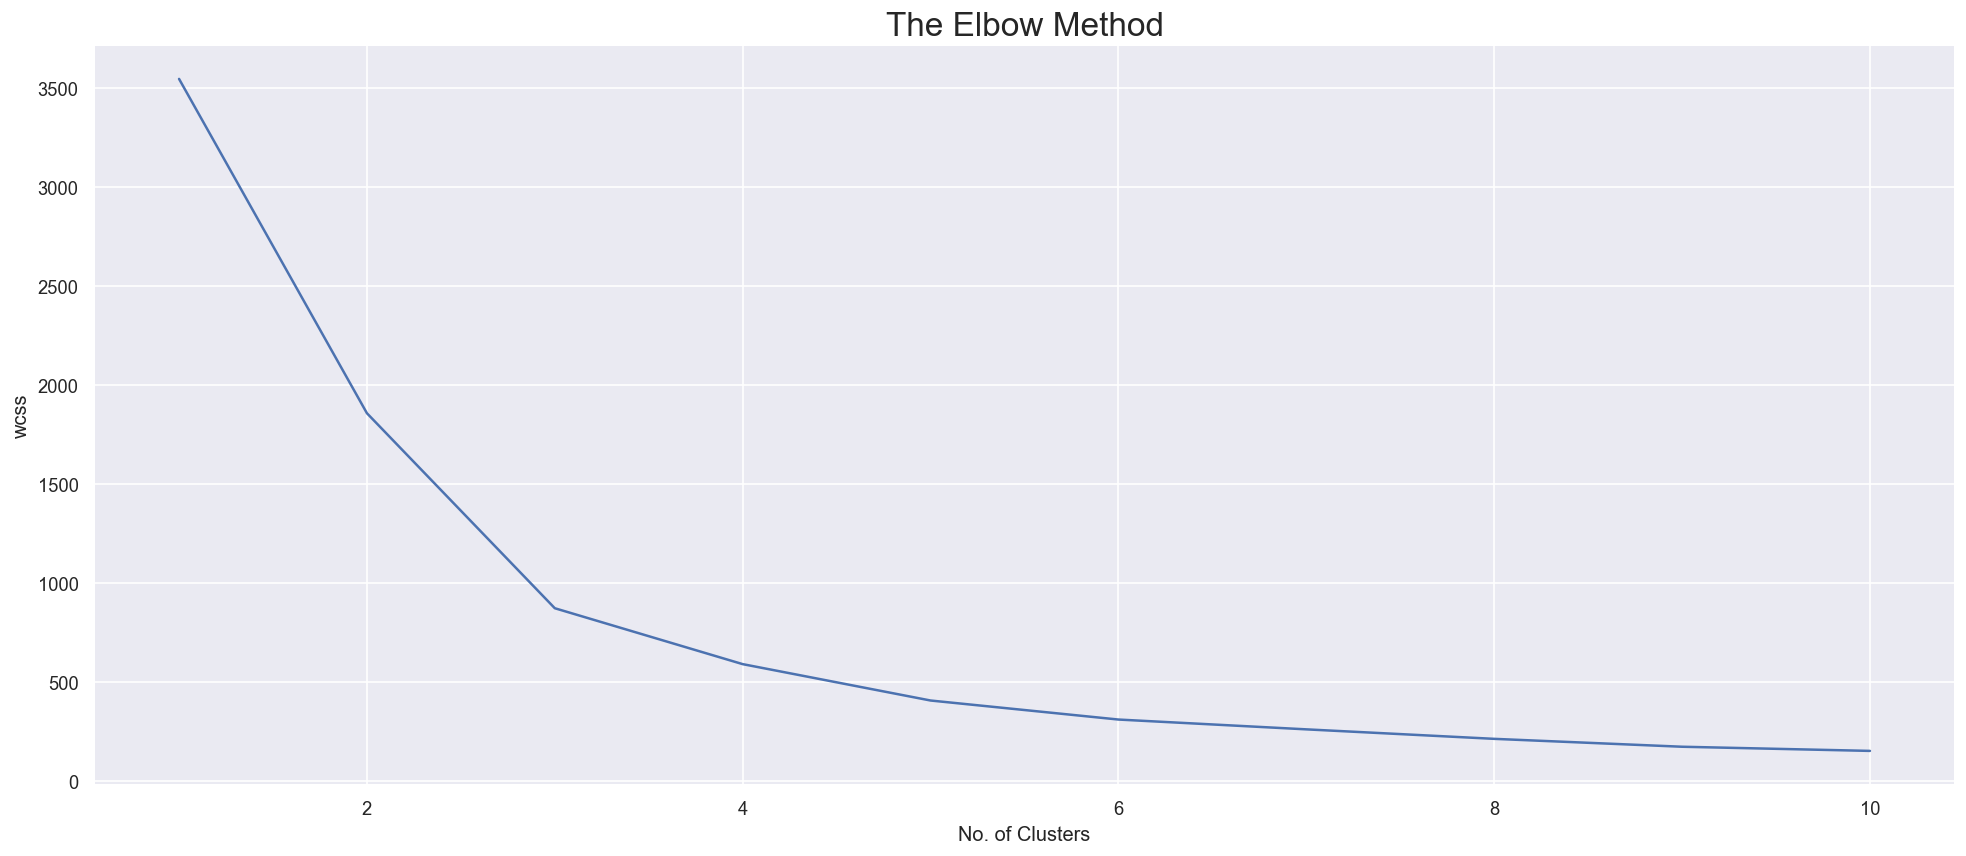

In [ ]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_seed)
    km.fit(data_sample)
    wcss.append(km.inertia_)

sns.set(style="darkgrid")
plt.figure(figsize=(20,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

Ci sono 3/4 clusters

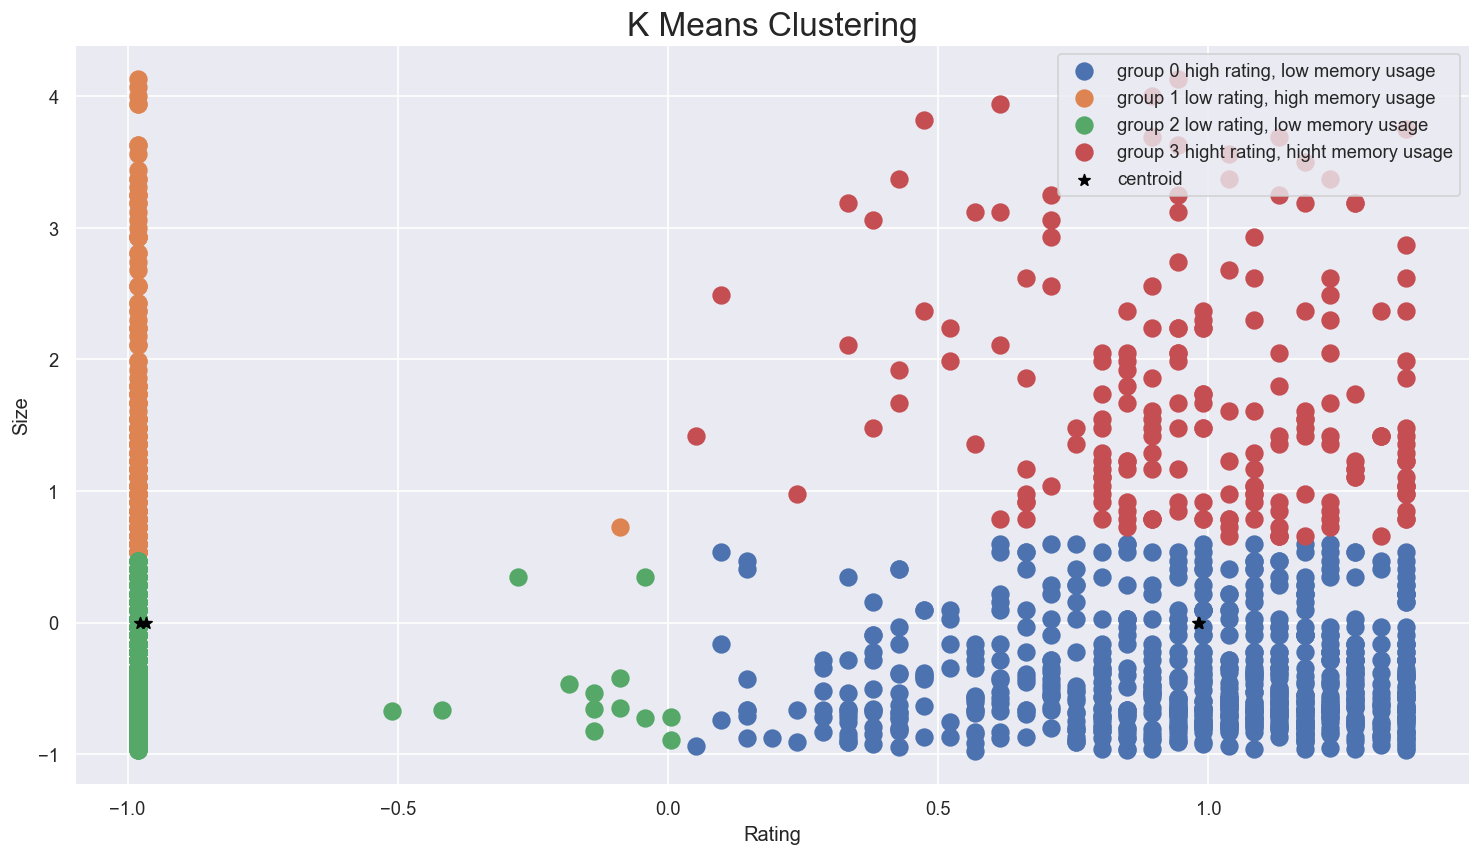

In [ ]:
n_clusters = 4
km = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_seed)
y_means = km.fit_predict(data_sample)
label=['high rating, low memory usage','low rating, high memory usage', 'low rating, low memory usage','hight rating, hight memory usage']
plt.figure(figsize=(15,8))
for i in range(n_clusters):
    plt.scatter(data_sample[y_means == i]['Rating'], data_sample[y_means == i]['Size'], s=100, label=f'group {i} {label[i]}')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'black' , marker='*', label = 'centroid')

plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('Rating')
plt.ylabel('Size')
plt.legend(loc='upper right')
plt.show()

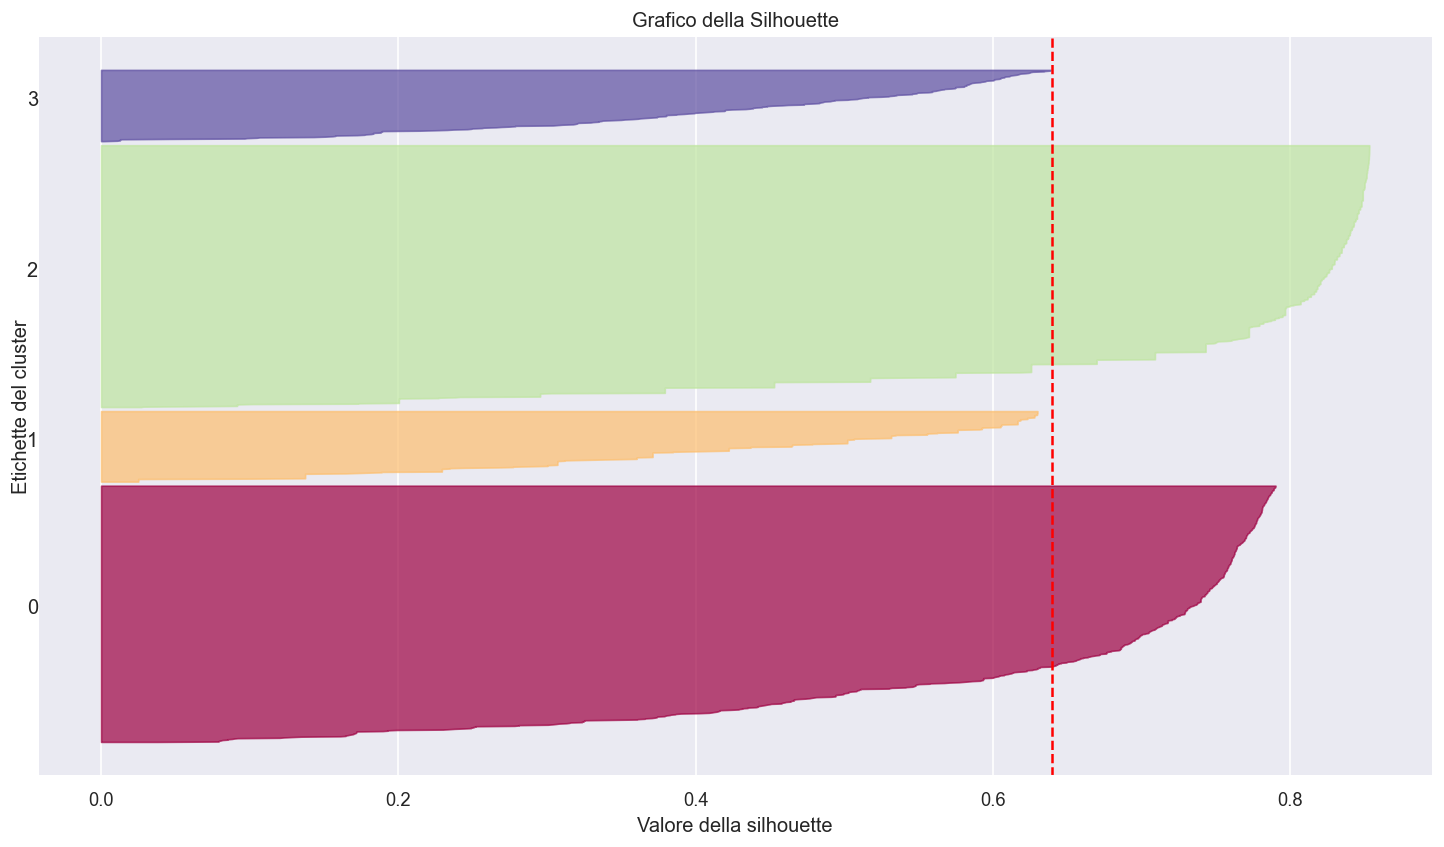

In [ ]:
plot_silhouette(data_sample, y_means)

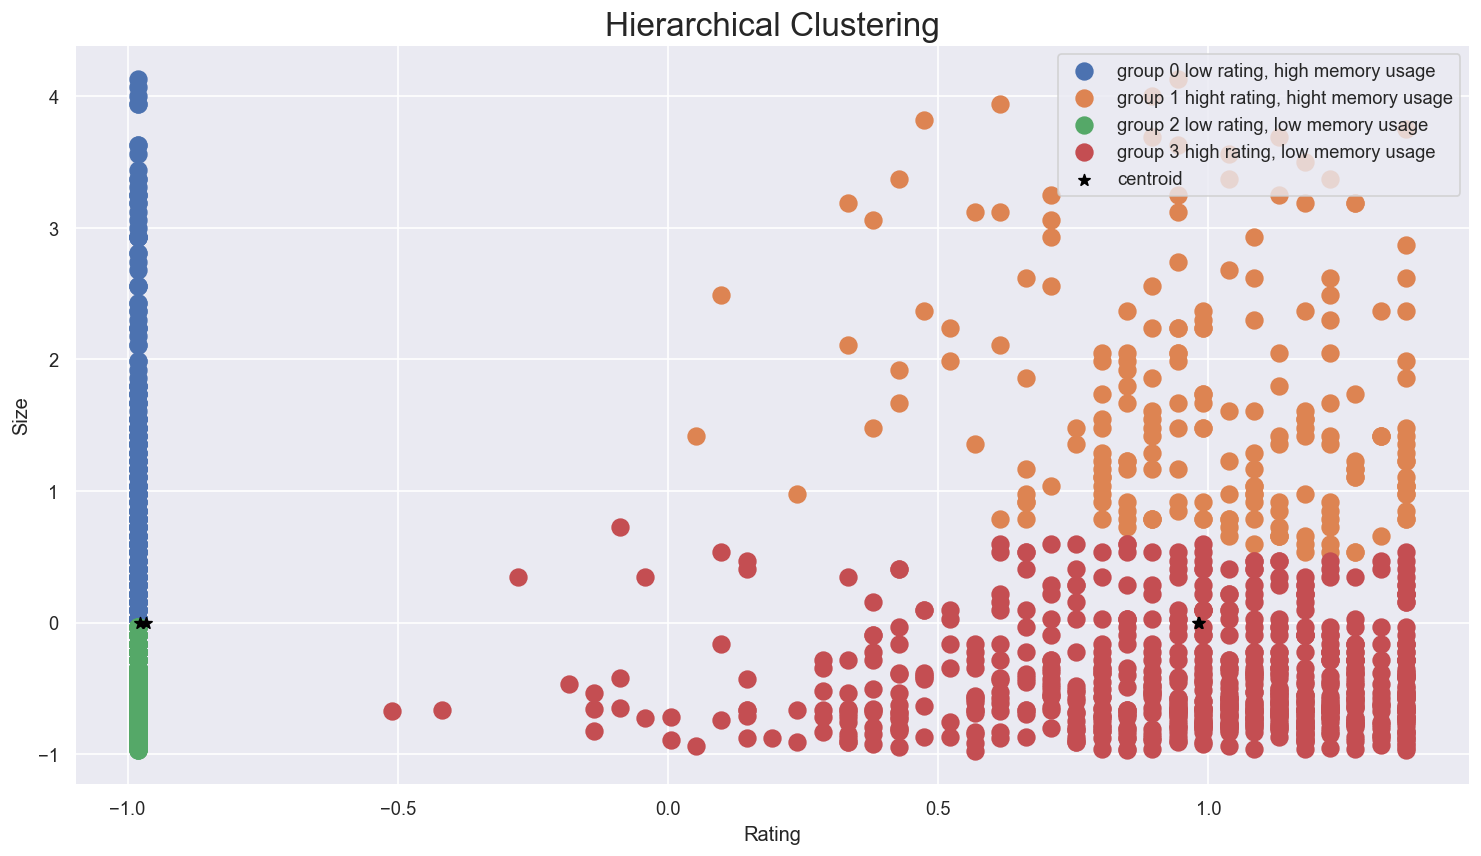

In [ ]:
n_clusters=4
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
y_agg = agg_clustering.fit_predict(data_sample)
label=['low rating, high memory usage', 'hight rating, hight memory usage', 'low rating, low memory usage', 'high rating, low memory usage']
plt.figure(figsize=(15,8))
for i in range(n_clusters):
    plt.scatter(data_sample[y_agg == i]['Rating'], data_sample[y_agg == i]['Size'], s=100, label=f'group {i} {label[i]}')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'black' , marker='*', label = 'centroid')

plt.title('Hierarchical Clustering', fontsize=20)
plt.xlabel('Rating')
plt.ylabel('Size')
plt.legend(loc='upper right')
plt.show()

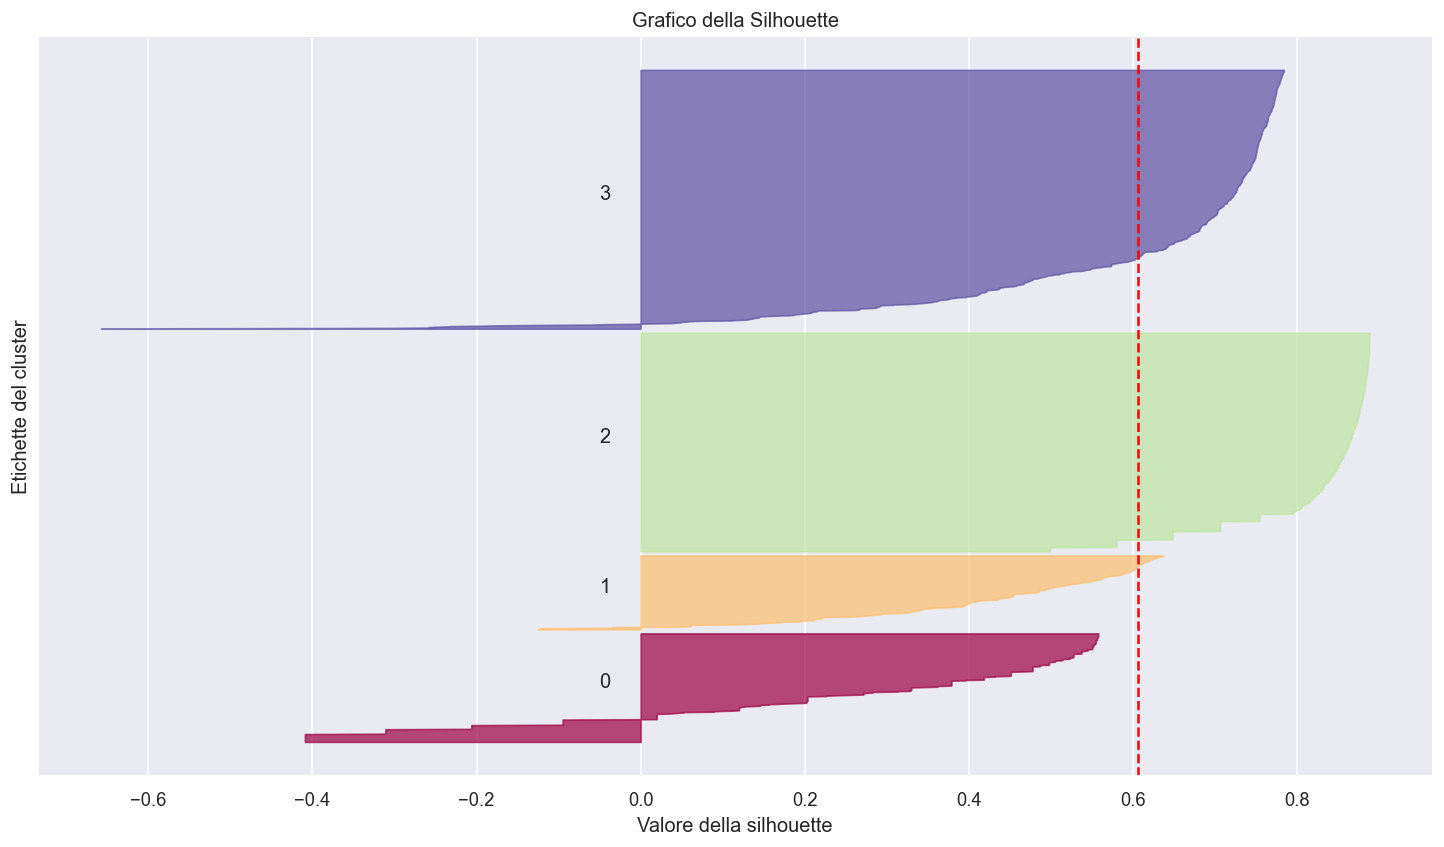

In [ ]:
plot_silhouette(data_sample, y_agg)

PCA analisi

Explained variance
[3.39531904e-01 2.64501790e-01 2.25244134e-01 1.70722172e-01
 1.81120417e-34]


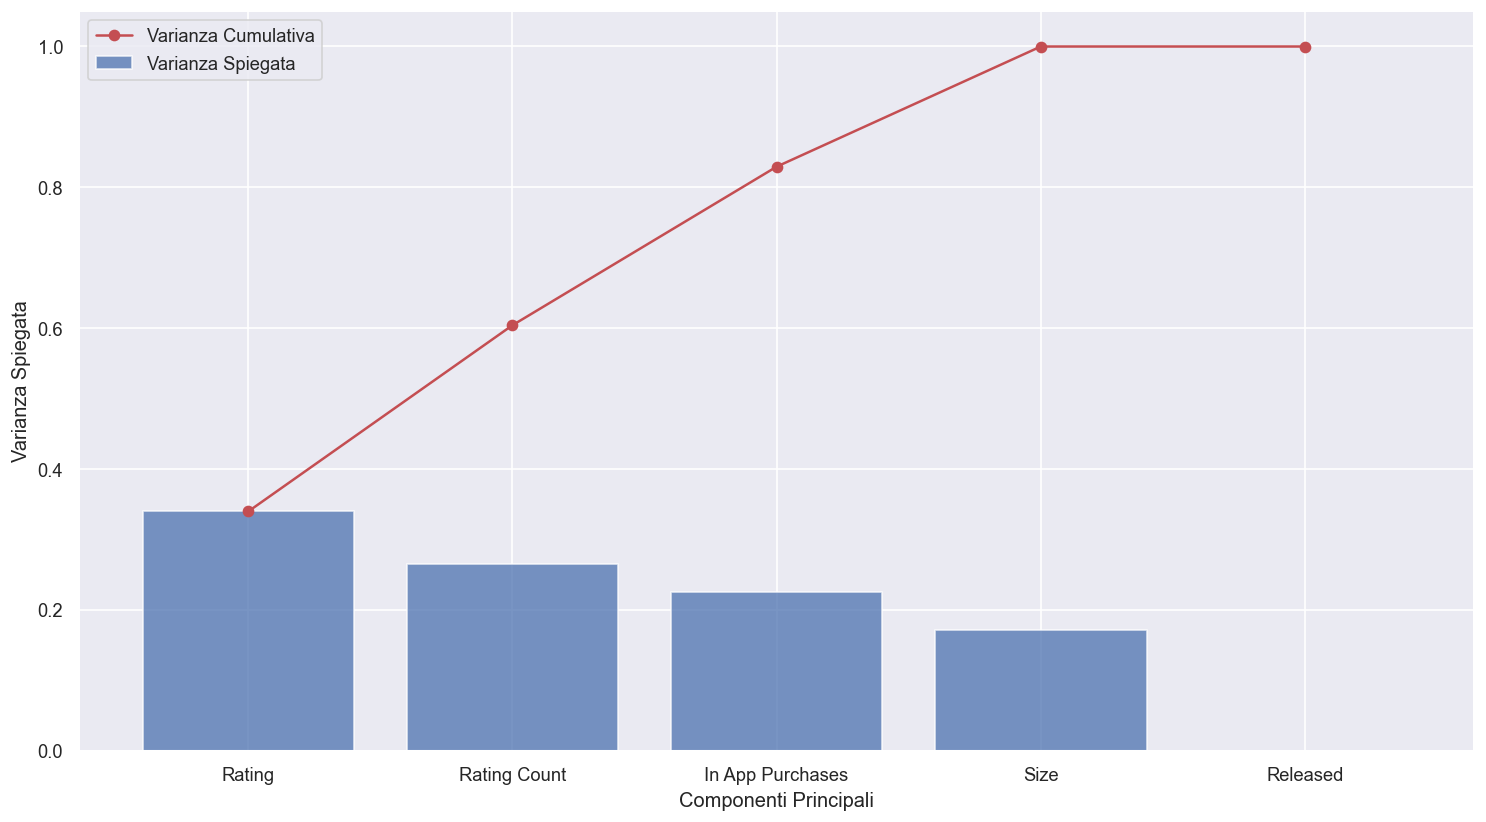

Carichi (Loadings):
     Rating  Rating Count  In App Purchases      Size  Released
0  0.593113      0.421792      1.110223e-16 -0.251347  -0.63807
1  0.357799      0.357129     -1.221245e-15  0.828032   0.24249
2 -0.380358      0.826947     -1.332268e-15 -0.281303   0.30390


In [ ]:
pca = PCA(n_components=len(data_pca.columns), svd_solver="auto").fit(data_pca)
pca_loadings = PCA(n_components=3, svd_solver="auto").fit(data_pca)
loadings = pd.DataFrame(pca_loadings.components_, columns=data_pca.columns)
explained_variance = pca.explained_variance_ratio_
print('Explained variance')
print(explained_variance)
cumulative_variance = np.cumsum(explained_variance)
component_labels = data_pca.columns
plt.bar(component_labels, explained_variance, label='Varianza Spiegata', alpha=0.75)
plt.plot(component_labels, cumulative_variance, marker='o', color='r', label='Varianza Cumulativa')
plt.xlabel('Componenti Principali')
plt.ylabel('Varianza Spiegata')
plt.legend()
plt.show() 
print('Carichi (Loadings):')
print(loadings)
pca = PCA(n_components=2, svd_solver="auto").fit(data_pca)
data_pca_transformed = pca.transform(data_pca)

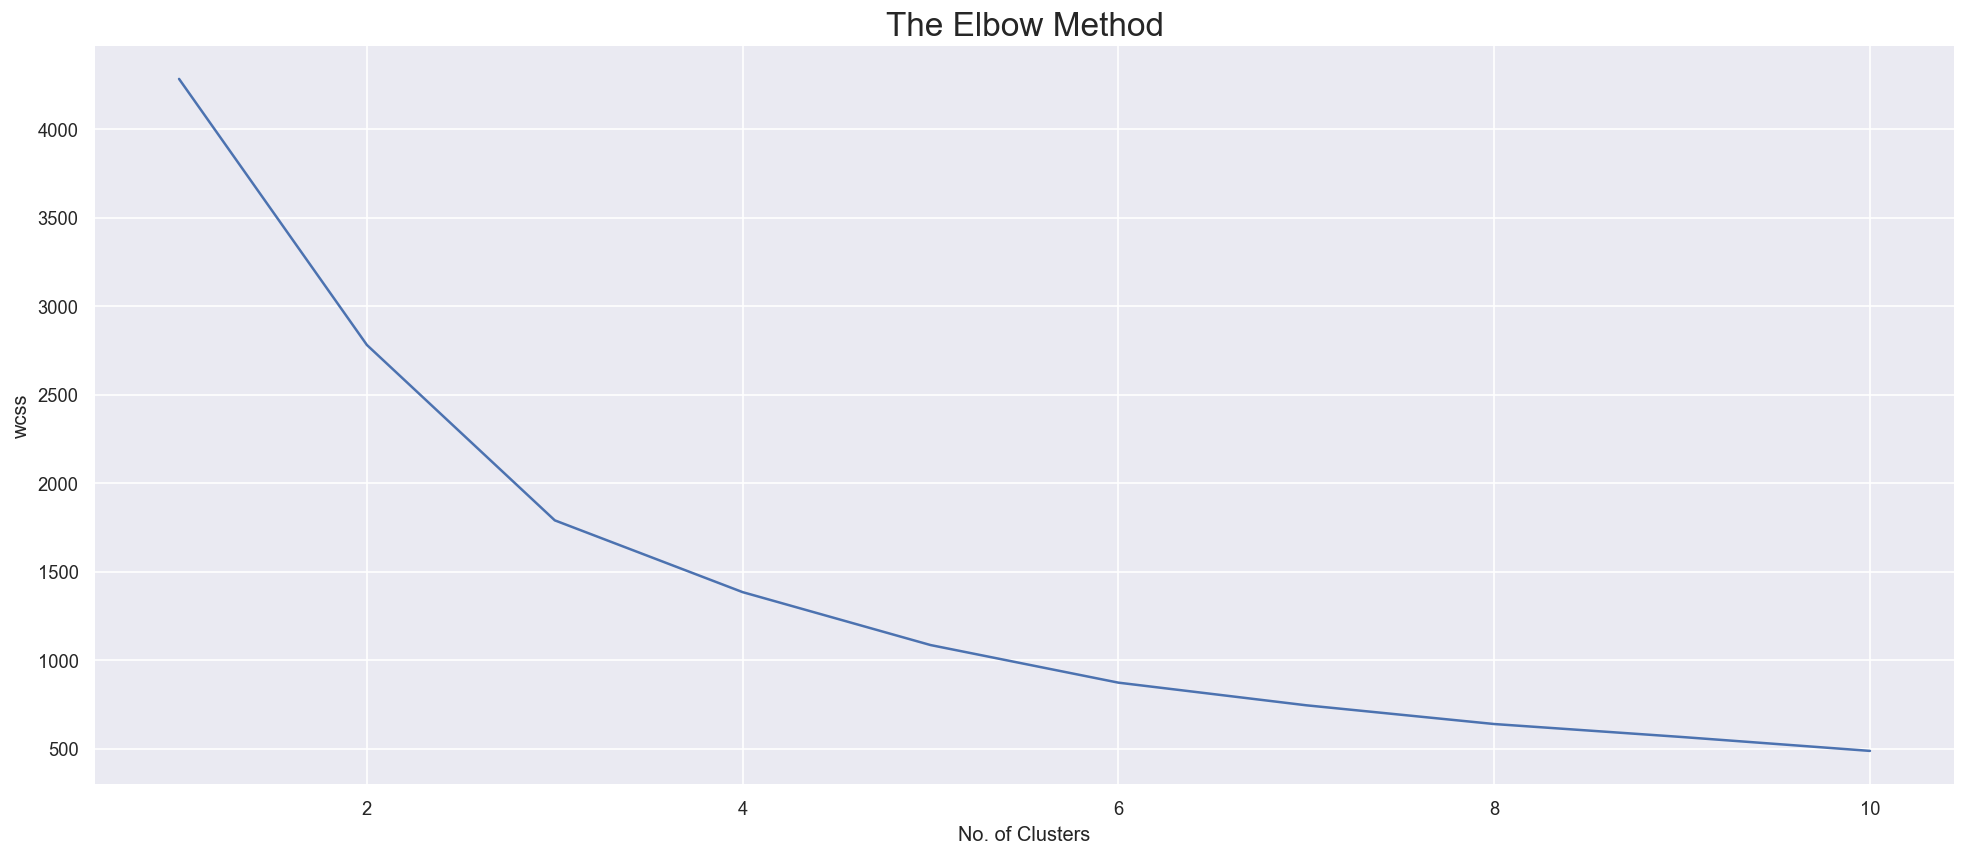

In [ ]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_seed)
    km.fit(data_pca_transformed)
    wcss.append(km.inertia_)

sns.set(style="darkgrid")
plt.figure(figsize=(20,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

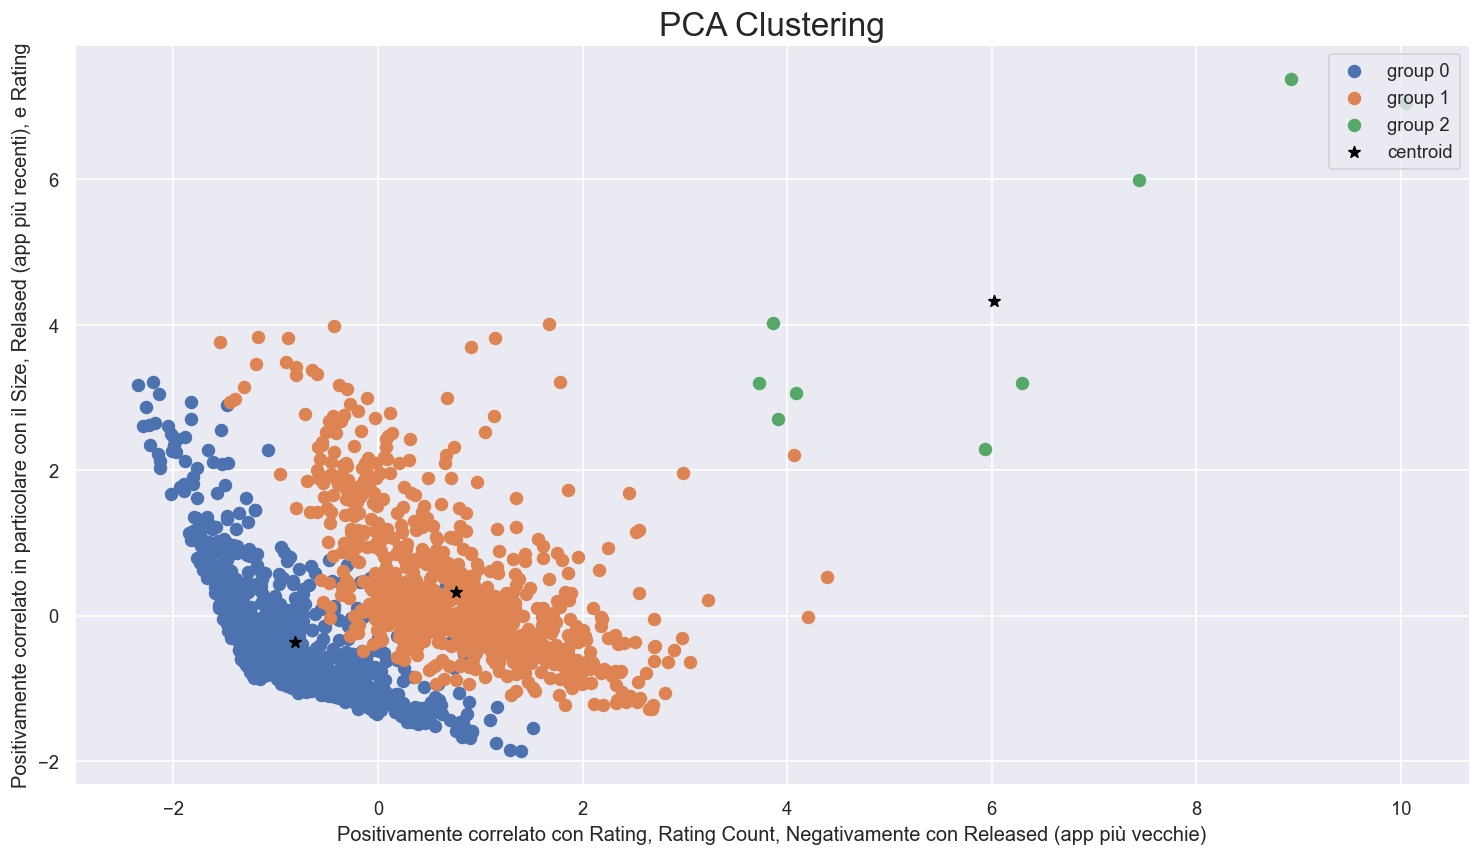

In [ ]:
n_clusters = 3
km = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_seed)
y_means = km.fit_predict(data_pca)
label=['low rating, low memory usage', 'low rating, high memory usage', 'high rating, high low memory usage', 'hight rating, hight memory usage']
plt.figure(figsize=(15,8))
for i in range(n_clusters):
    plt.scatter(data_pca_transformed[y_means == i][:, 0], data_pca_transformed[y_means == i][:, 1], s=50, label=f'group {i}')
centers = pca.transform(km.cluster_centers_)
plt.scatter(centers[:,0], centers[:, 1], s = 50, c = 'black' , marker='*', label = 'centroid')

plt.title('PCA Clustering', fontsize = 20)
plt.xlabel('Positivamente correlato con Rating, Rating Count, Negativamente con Released (app più vecchie)')
plt.ylabel('Positivamente correlato in particolare con il Size, Relased (app più recenti), e Rating')
plt.legend(loc='upper right')
plt.show()

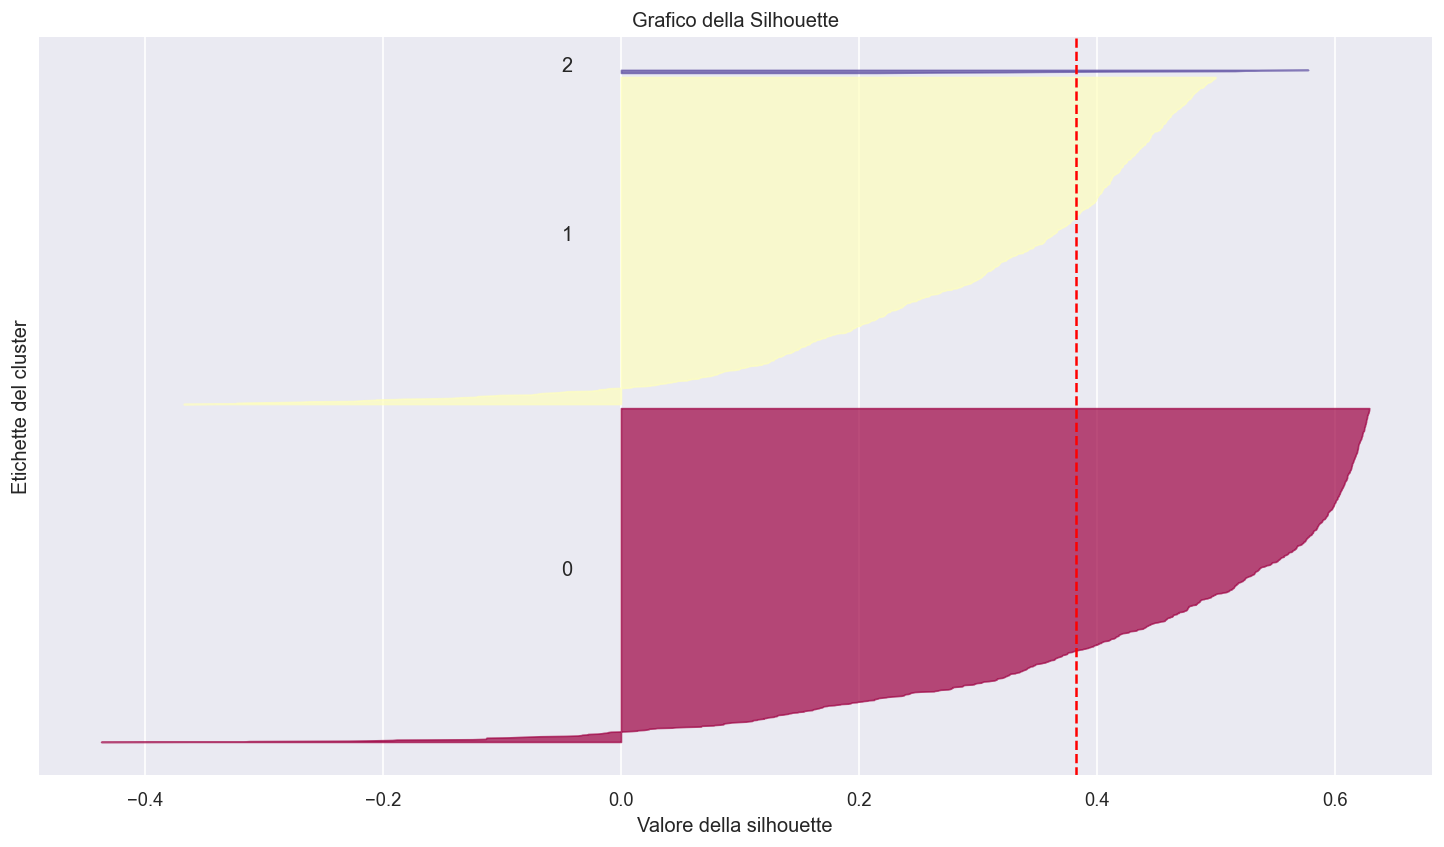

In [ ]:
plot_silhouette(data_pca_transformed, y_means)

clustering multidimensionale

In [ ]:
pca = PCA(n_components=3, svd_solver="auto").fit(data_pca)
data_pca_transformed = pca.transform(data_pca)

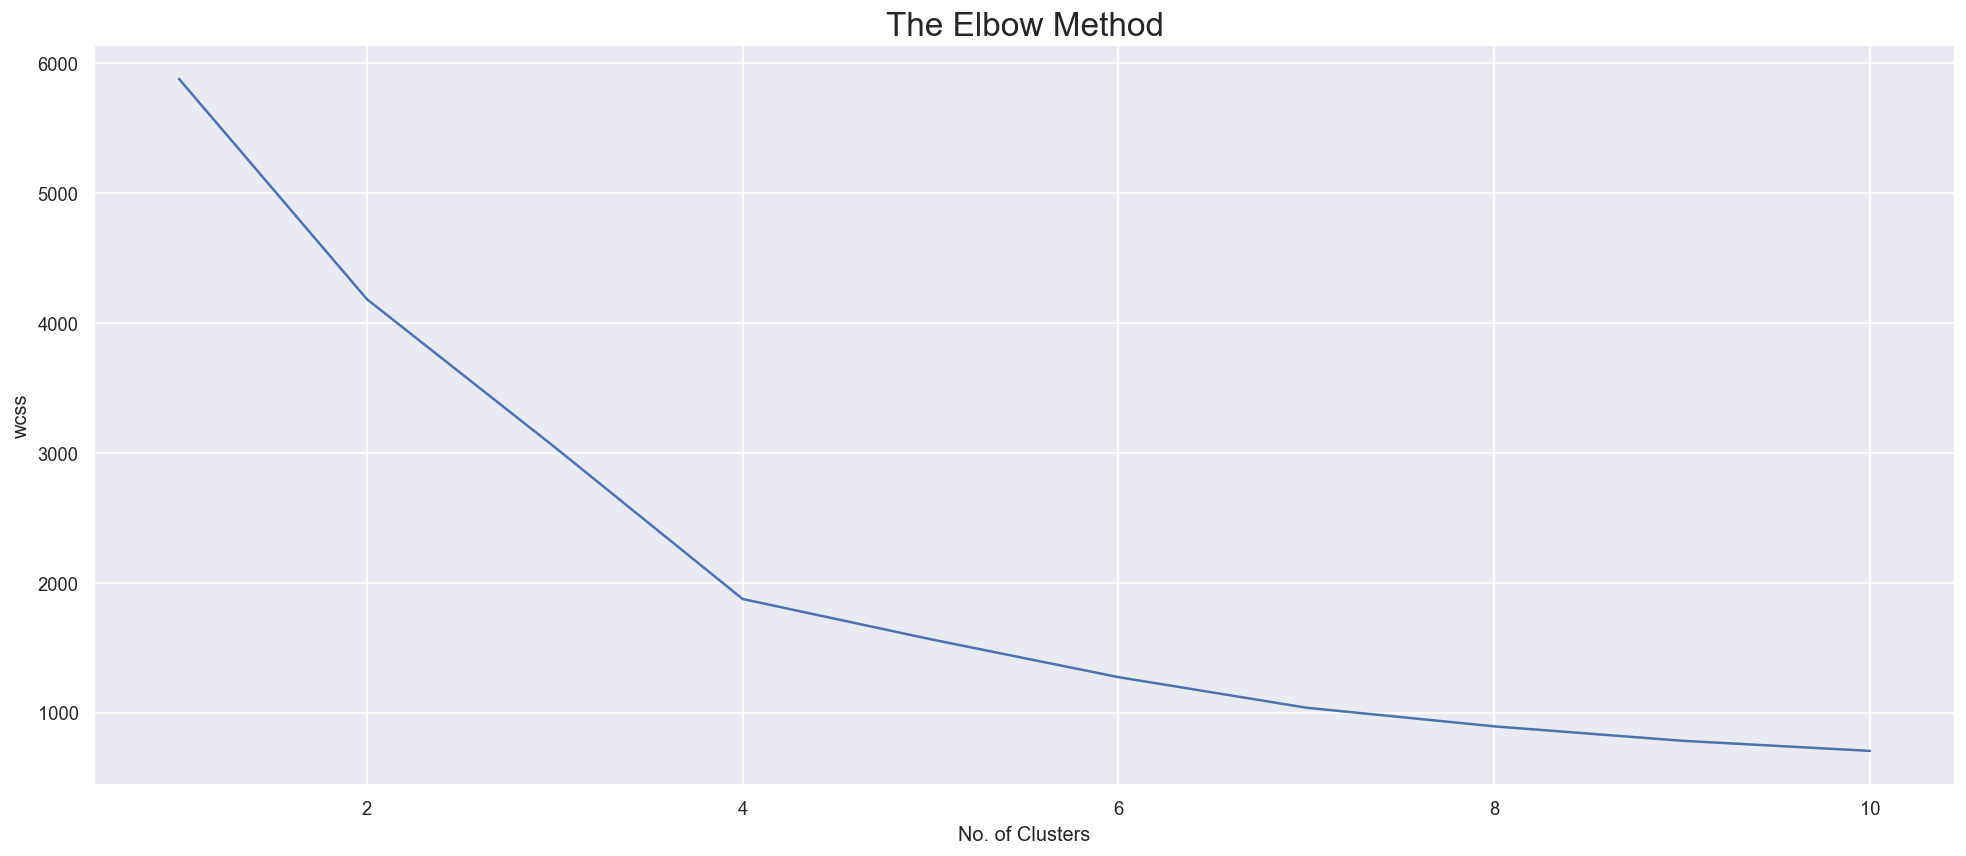

In [ ]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_seed)
    km.fit(data_pca_transformed)
    wcss.append(km.inertia_)

sns.set(style="darkgrid")
plt.figure(figsize=(20,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

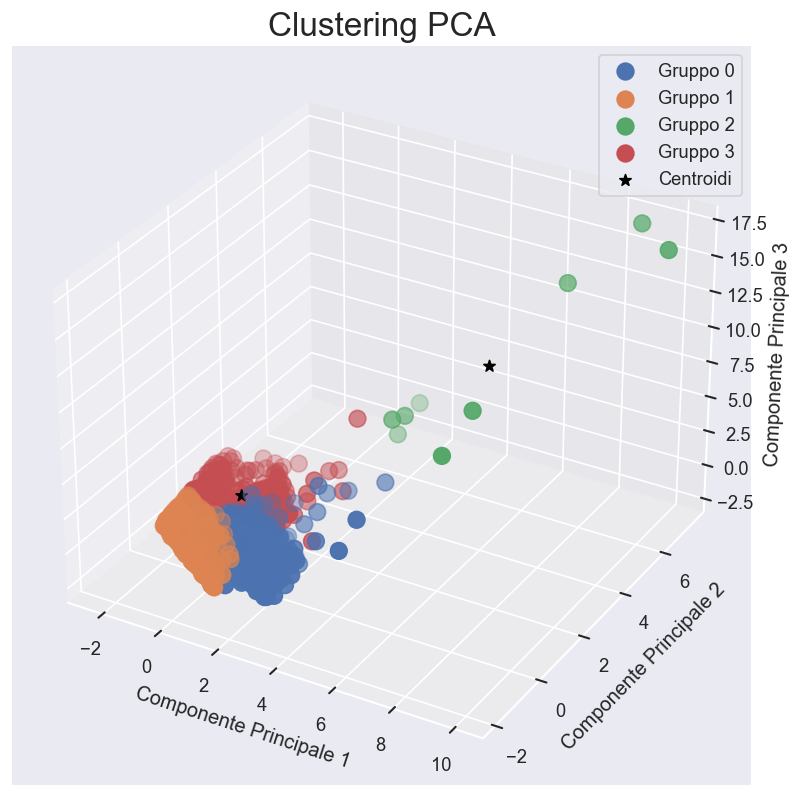

In [ ]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=random_seed)
y_means = km.fit_predict(data_pca)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
centers = pca.transform(km.cluster_centers_)
for i in range(n_clusters):
    ax.scatter(data_pca_transformed[y_means == i][:, 0], data_pca_transformed[y_means == i][:, 1], data_pca_transformed[y_means == i][:, 2], s=100, label=f'Gruppo {i}')
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=50, c='black', alpha=1, marker='*', label='Centroidi', zorder=100)
ax.set_xlabel('Componente Principale 1')
ax.set_ylabel('Componente Principale 2')
ax.set_zlabel('Componente Principale 3')
ax.mouse_init()
plt.title('Clustering PCA', fontsize=20)
plt.legend(loc='upper right')
plt.show()

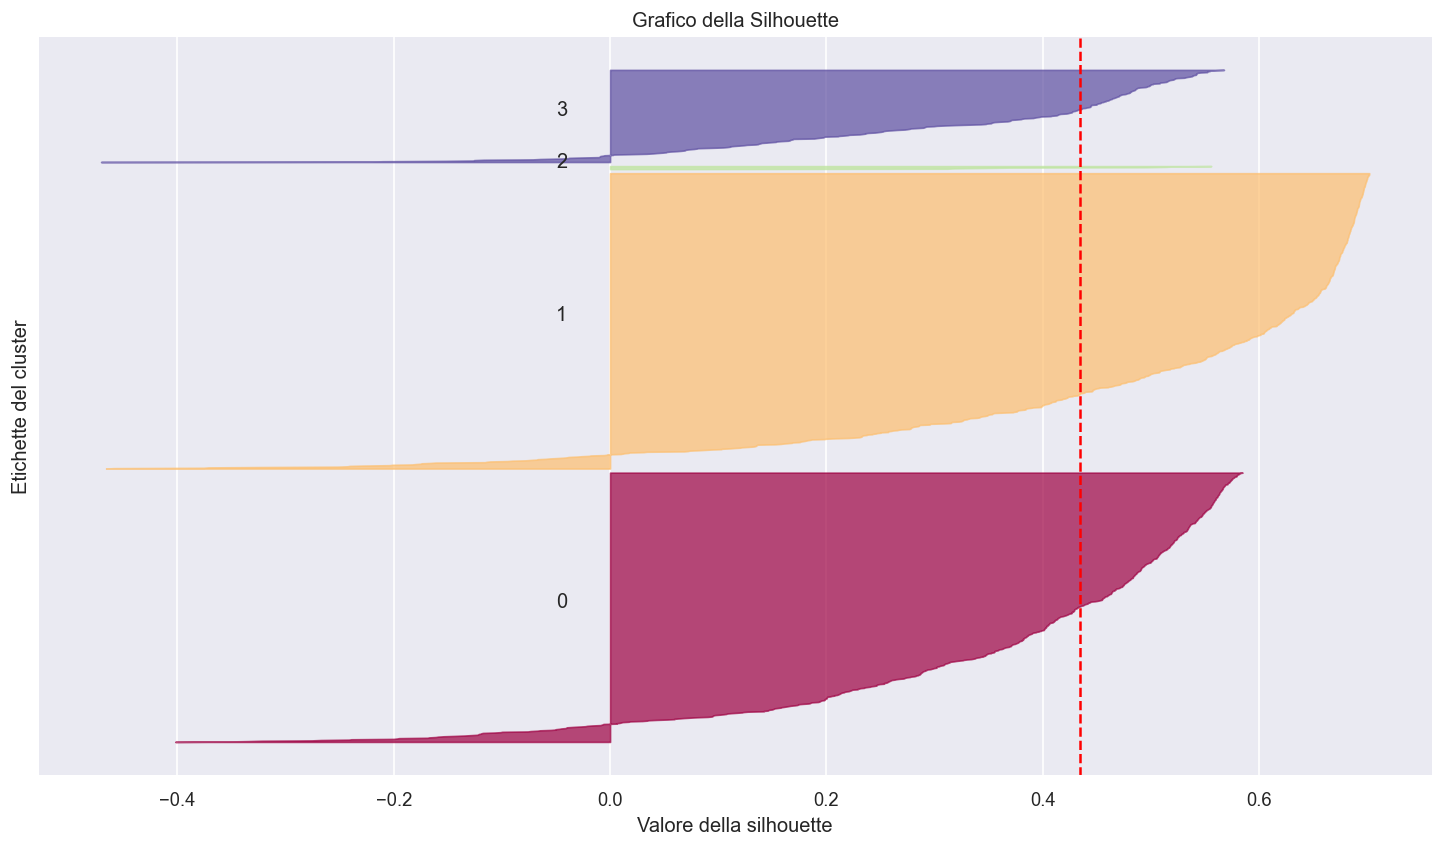

In [ ]:
plot_silhouette(data_pca_transformed, y_means)

riduzione dmensionalità tramite TSNE

In [ ]:
tsne = TSNE(n_components=3, random_state=random_seed)
data_tsne = tsne.fit_transform(data_old)

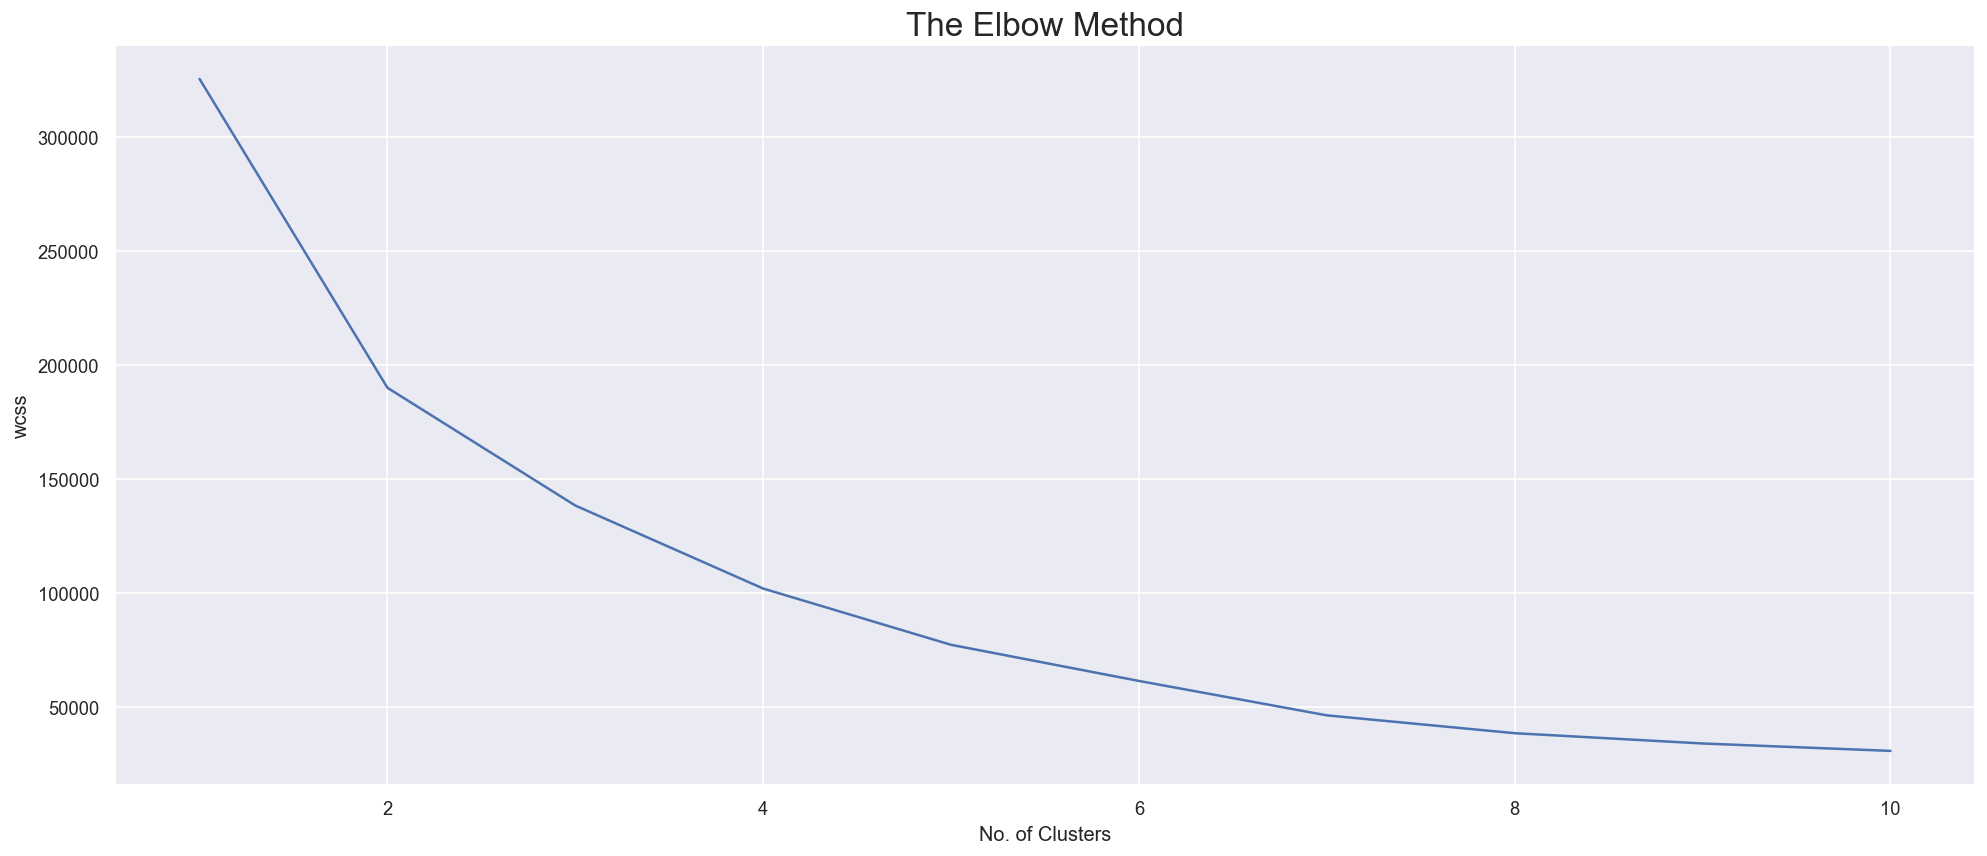

In [ ]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_seed)
    km.fit(data_tsne)
    wcss.append(km.inertia_)

sns.set(style="darkgrid")
plt.figure(figsize=(20,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

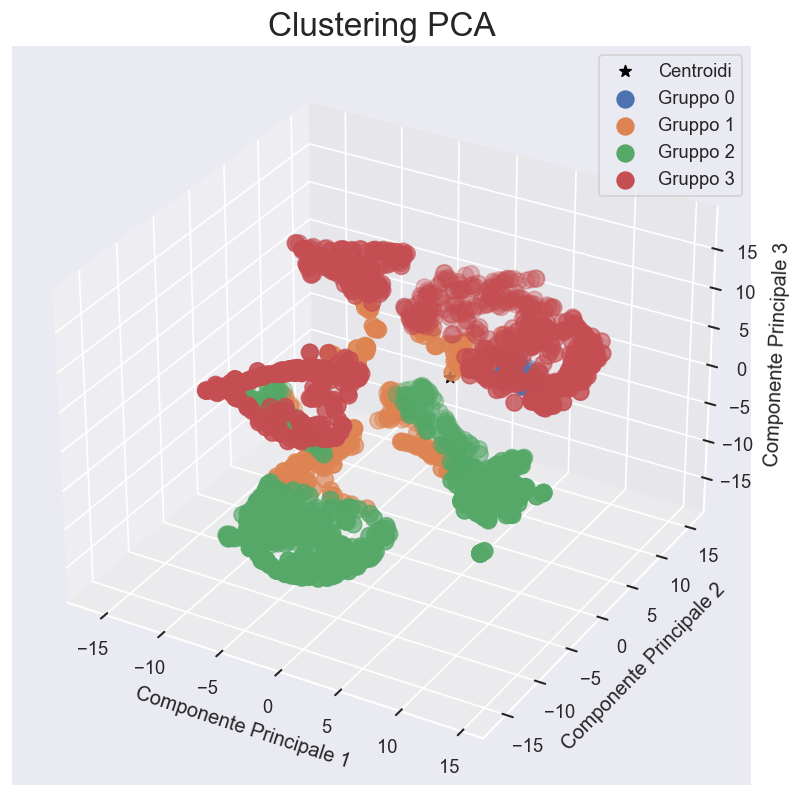

In [ ]:
n_clusters = 4
km = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_seed)
y_means = km.fit_predict(data_old)
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
centers = km.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=50, c='black', alpha=1, marker='*', label='Centroidi', zorder=10)
for i in range(n_clusters):
    #create_3d_figure(data_tsne[y_means == i][:, 0], data_tsne[y_means == i][:, 1], data_tsne[y_means == i][:, 2], x_title="X", y_title="Y", z_title="Z", title="3D Plot")
    ax.scatter(data_tsne[y_means == i][:, 0], data_tsne[y_means == i][:, 1], data_tsne[y_means == i][:, 2], s=100, label=f'Gruppo {i}')
ax.set_xlabel('Componente Principale 1')
ax.set_ylabel('Componente Principale 2')
ax.set_zlabel('Componente Principale 3')

plt.title('Clustering PCA', fontsize=20)
plt.legend(loc='upper right')
plt.show()

DBSCAN

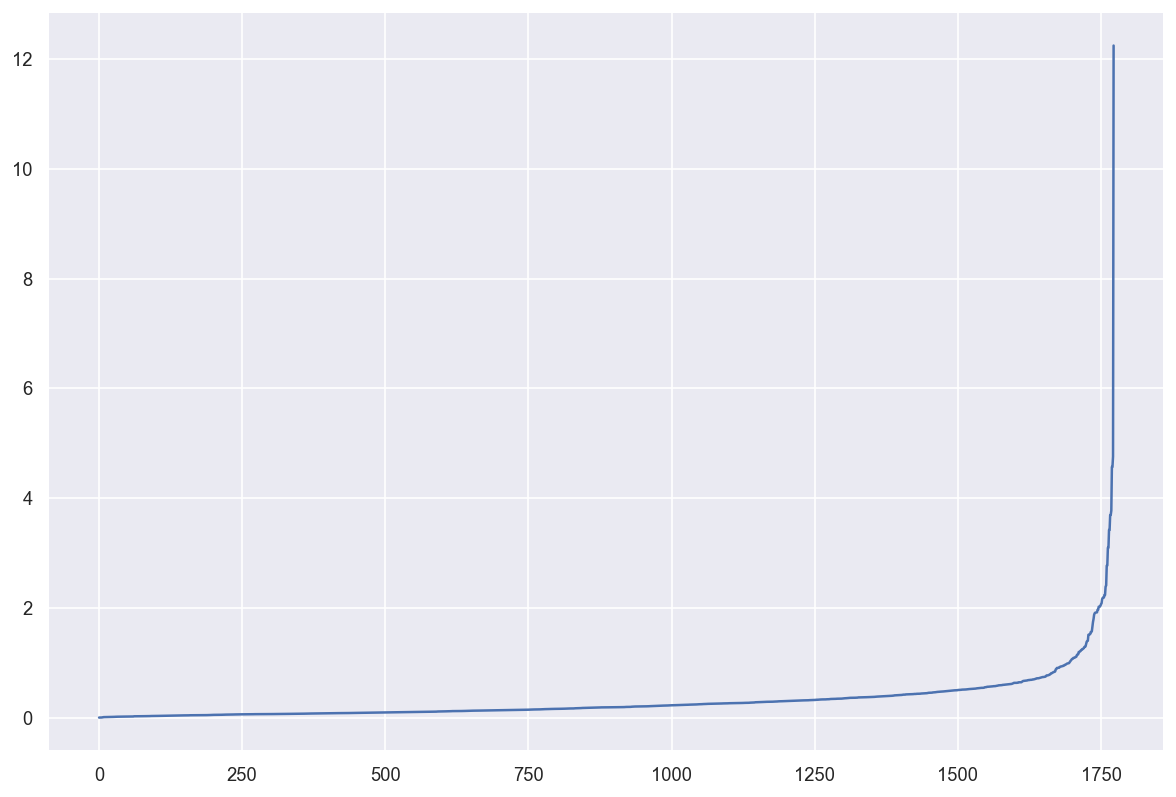

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_old)
distances, indices = nbrs.kneighbors(data_old)

distances = np.sort(distances, axis=0)
plt.figure(figsize=(12,8))
plt.plot(distances[:,1])
plt.show()

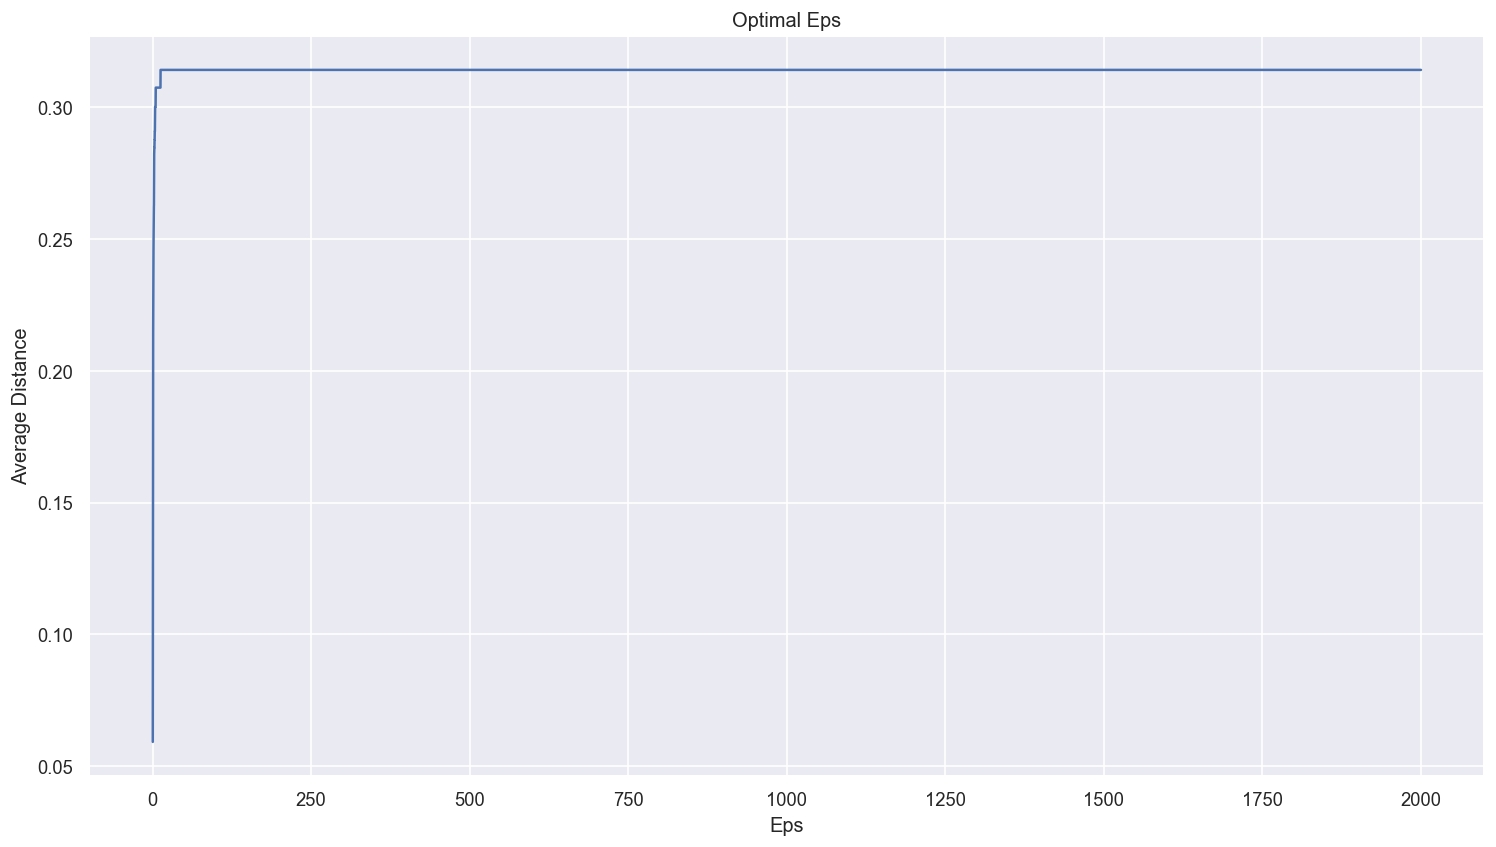

12.3


In [ ]:
optimal_eps = find_optimal_eps(data_old, min_eps=0.1, max_eps=2000, step=0.1)
print(optimal_eps)

In [ ]:
db = DBSCAN(eps=optimal_eps, min_samples=5).fit(data_pca)
ymeans = db.labels_
ymeans

array([0, 0, 0, ..., 0, 0, 0])

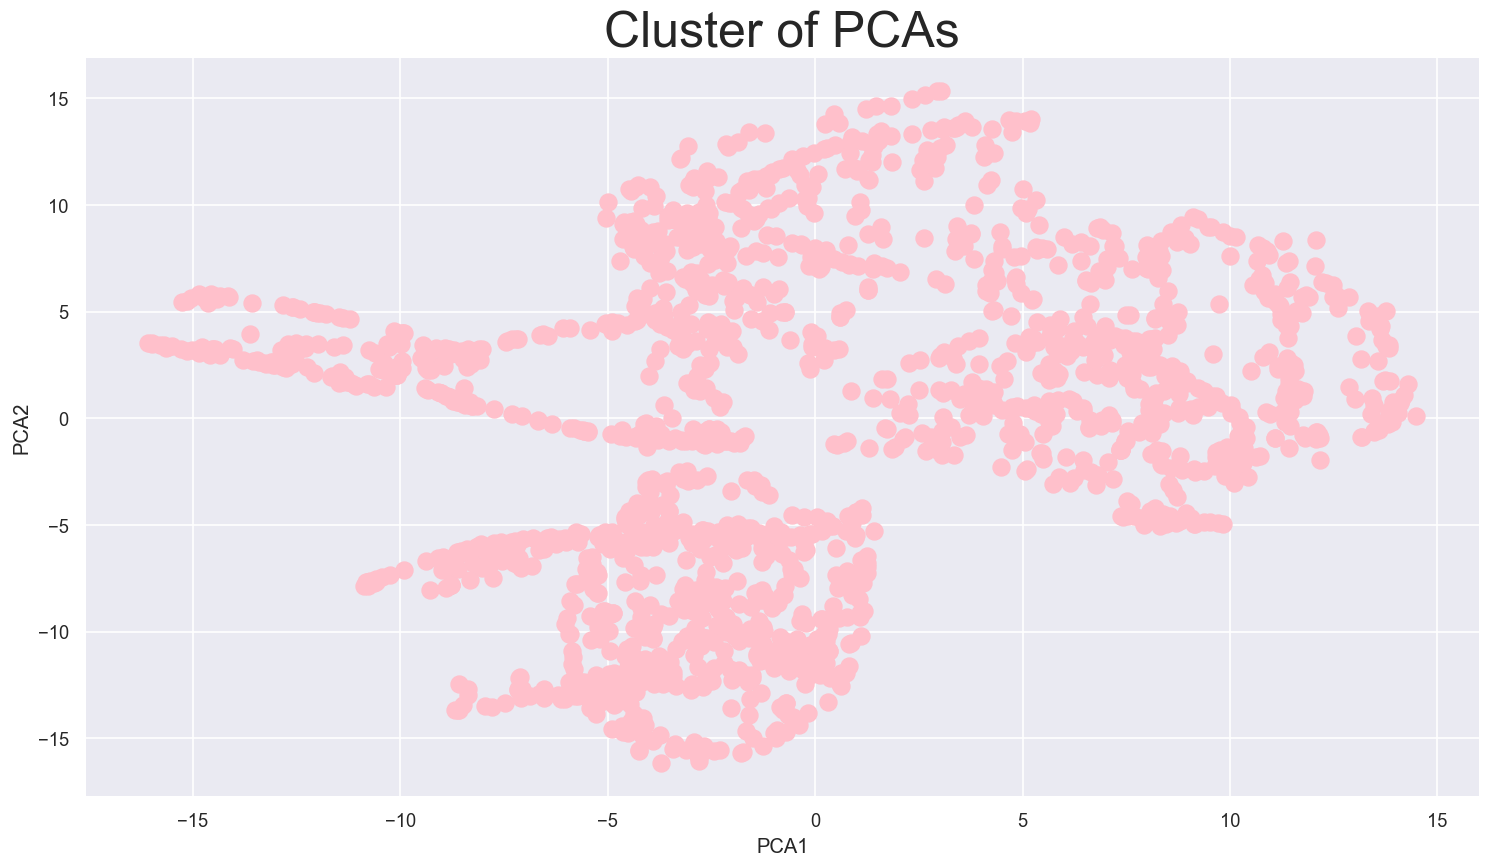

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Cluster of PCAs', fontsize = 30)

plt.scatter(data_tsne[ymeans == -1, 0], data_tsne[ymeans == -1, 1], s = 100, c = 'black')
plt.scatter(data_tsne[ymeans == 0, 0], data_tsne[ymeans == 0, 1], s = 100, c = 'pink')
plt.scatter(data_tsne[ymeans == 1, 0], data_tsne[ymeans == 1, 1], s = 100, c = 'orange')
plt.scatter(data_tsne[ymeans == 2, 0], data_tsne[ymeans == 2, 1], s = 100, c = 'lightgreen')
plt.scatter(data_tsne[ymeans == 3, 0], data_tsne[ymeans == 3, 1], s = 100, c = 'blue')
plt.scatter(data_tsne[ymeans == 4, 0], data_tsne[ymeans == 4, 1], s = 100, c = 'gray')
plt.scatter(data_tsne[ymeans == 5, 0], data_tsne[ymeans == 5, 1], s = 100, c = 'red')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [11]:
tsne = TSNE(n_components=2, random_state=random_seed)
data_tsne = tsne.fit_transform(data_old)

NameError: name 'data_old' is not defined

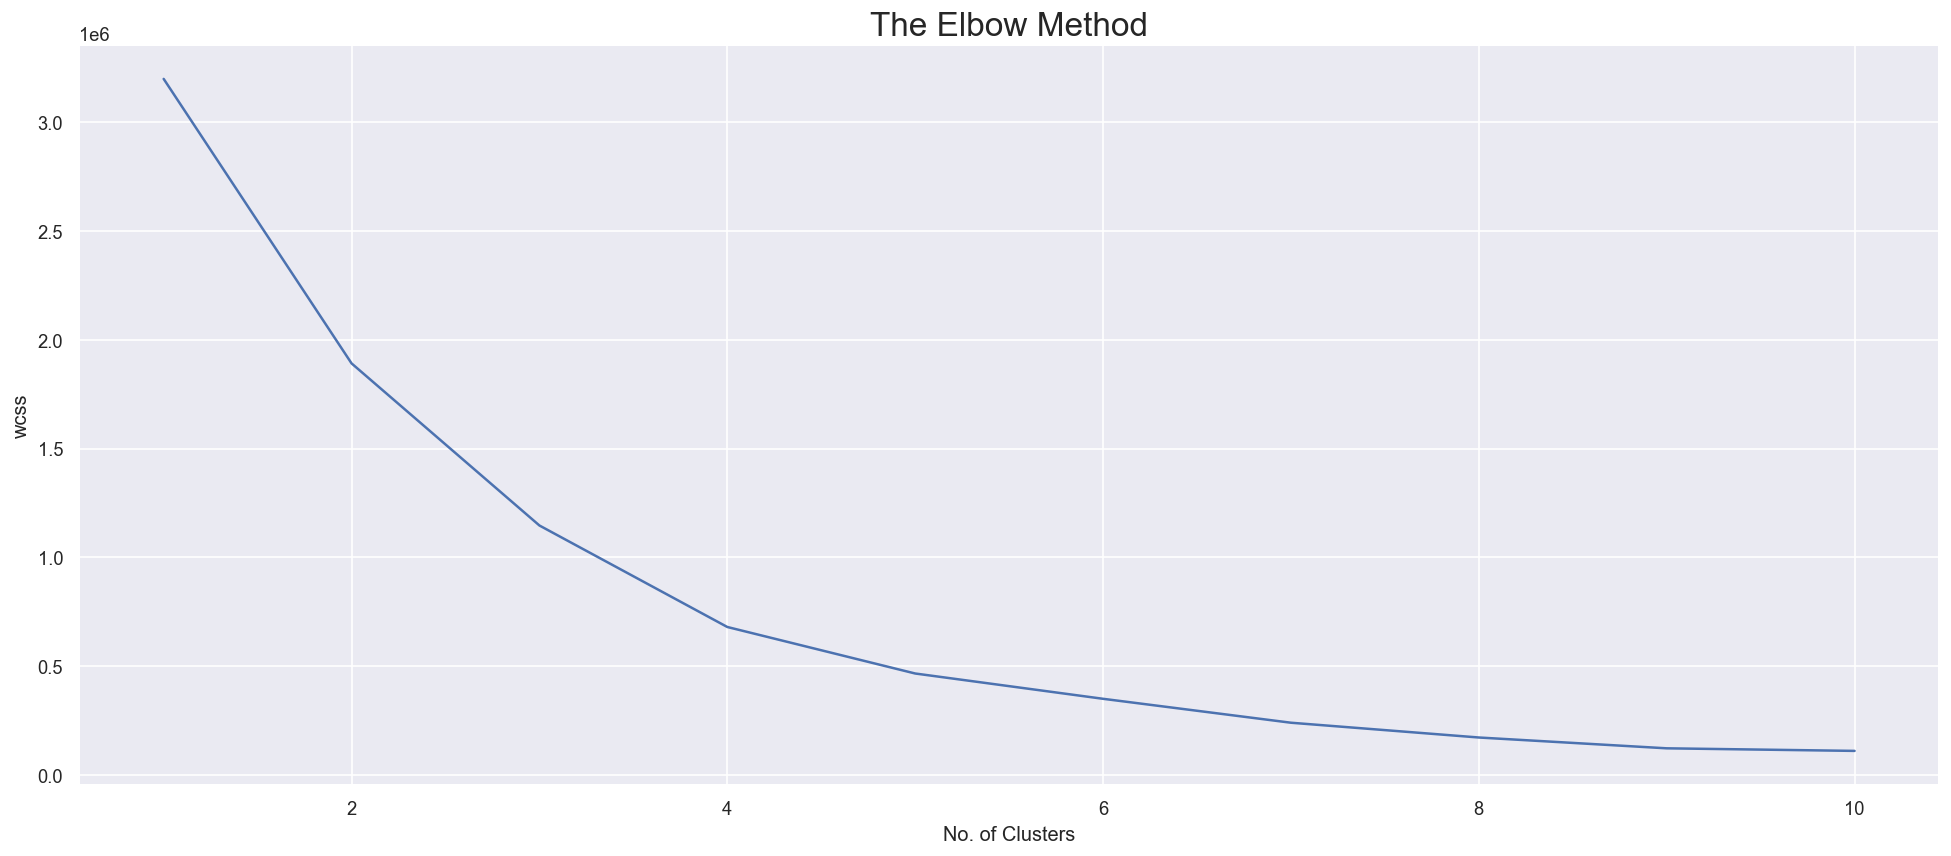

In [ ]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_seed)
    km.fit(data_tsne)
    wcss.append(km.inertia_)

sns.set(style="darkgrid")
plt.figure(figsize=(20,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

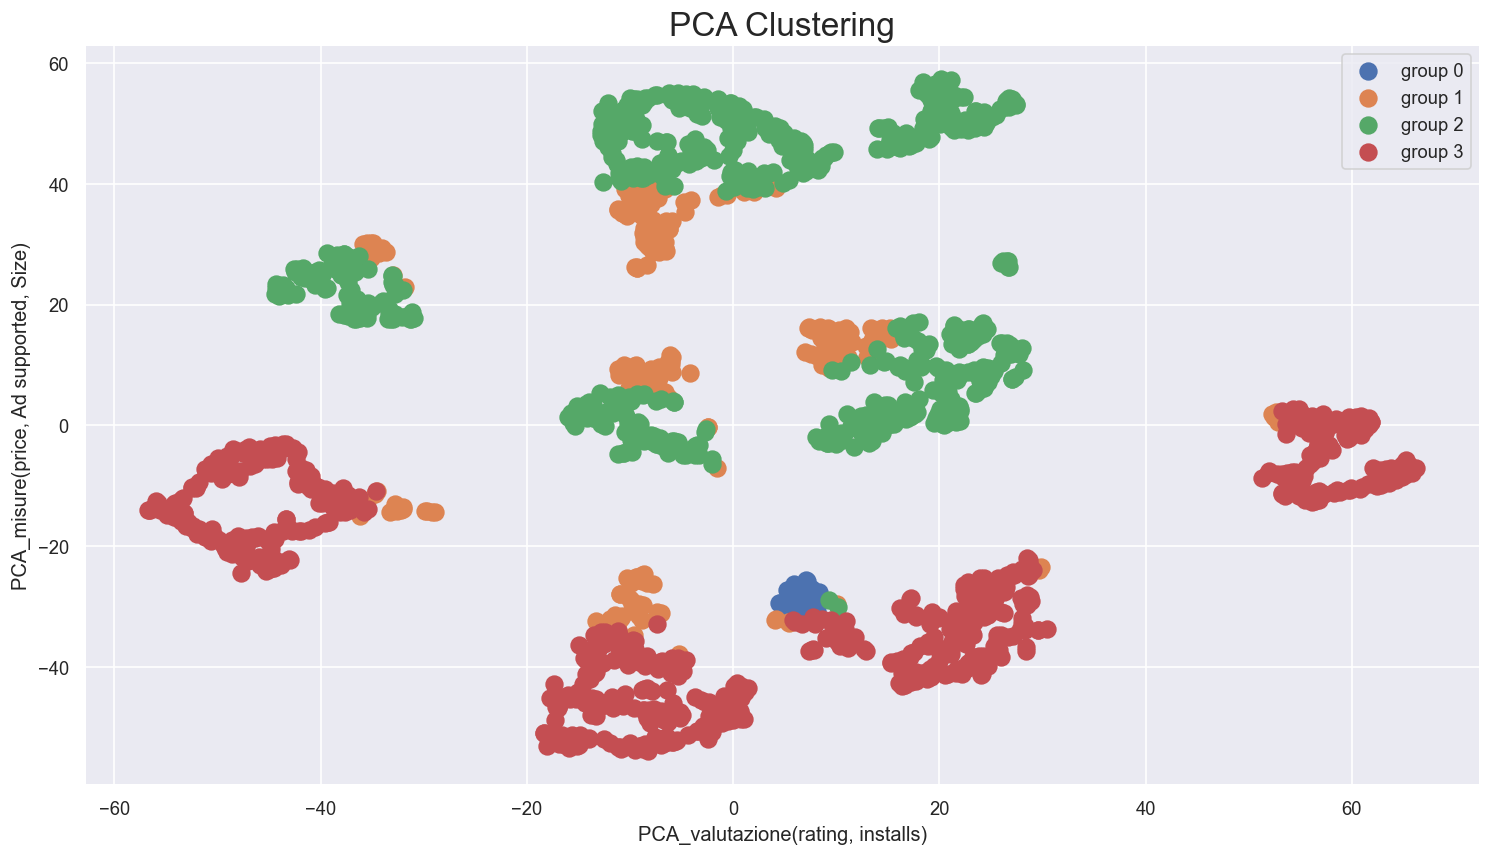

In [ ]:
n_clusters = 4
km = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_seed)
y_means = km.fit_predict(data_old)
plt.figure(figsize=(15,8))
for i in range(n_clusters):
    plt.scatter(data_tsne[y_means == i][:, 0], data_tsne[y_means == i][:, 1], s=100, label=f'group {i}')
plt.title('PCA Clustering', fontsize = 20)
plt.xlabel('PCA_valutazione(rating, installs)')
plt.ylabel('PCA_misure(price, Ad supported, Size)')
plt.legend(loc='upper right')
plt.show()